In [1]:
# Necessary Imports
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import entropy
import yaml
from typing import List

/home/kwilliams/dev/stolen-probability-ptl/venv-torch-1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Pre-Processing and Data Loading
'''
def make_head_csvs(experiment_dir: Path, stride: int, wdw: int, delete: bool=False) -> List[int]:
    # Find out how many heads this experiment has
    yaml_path = experiment_dir / 'hparams.yaml'
    with yaml_path.open('r') as yaml_file:
        n_heads = yaml.safe_load(yaml_file)['num_heads']

    # Load ndarray storing token ids in each batch. Gather batch IDs from the stride
    token_ids_path = experiment_dir / f'token_ids-wdw={wdw}-stride={stride}.npy'
    try:
        token_ids = np.load(token_ids_path)
    except FileNotFoundError:
        print(f"No token IDs found... was this function previously run with delete=True?")
        return
    
    token_ids_df = pd.DataFrame(token_ids, columns=[f'token_id_{i}' for i in range(wdw)])
    batch_nos = [i*stride for i in range(len(token_ids))]

    # Load the weights, norms, and query_norms for each head. Combine this information with the token ids and save a CSV to disk
    for i in range(n_heads):
        norms_path = experiment_dir / f'attn_norms-wdw={wdw}-stride={stride}-head={i}.npy'
        weights_path = experiment_dir / f'attn_weights-wdw={wdw}-stride={stride}-head={i}.npy'
        q_norms_path = experiment_dir / f'attn_query_norms-wdw={wdw}-stride={stride}-head={i}.npy'

        try:
            norms = np.load(norms_path)
            weights = np.load(weights_path)
            q_norms = np.load(q_norms_path)
        except FileNotFoundError:
            print(f"No attention statistics found for head {i} with window {wdw} and stride {stride}!")
            return

        norms_df = pd.DataFrame(norms, columns=[f'norm_{i}' for i in range(wdw)])
        weights_df = pd.DataFrame(weights, columns=[f'weight_{i}' for i in range(wdw)])

        total_df = pd.concat([token_ids_df, norms_df, weights_df], axis=1)
        total_df['query_norm'] = q_norms
        total_df['batch_id'] = batch_nos

        total_df.to_csv(experiment_dir / f'attn-stats-wdw={wdw}-stride={stride}-head={i}.csv', index=False)

        # Clean the numpy arrays from disk
        if delete:
            norms_path.unlink()
            weights_path.unlink()
            q_norms_path.unlink()

    # Clean the token ids array from disk
    if delete:
        token_ids_path.unlink()

In [4]:
'''
Call the Pre-Processor Function
'''
EXPERIMENT_DIR = Path('./experiments/1_layer_8_heads/oracle')
STRIDE=128
WINDOW_LENGTH=512
make_head_csvs(EXPERIMENT_DIR, STRIDE, WINDOW_LENGTH, delete=True)

No token IDs found... was this function previously run with delete=True?


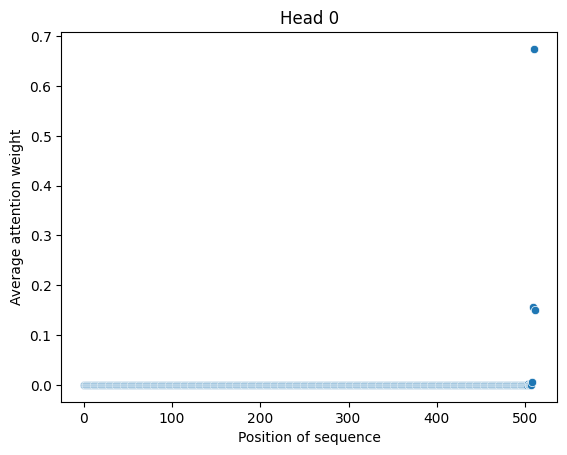

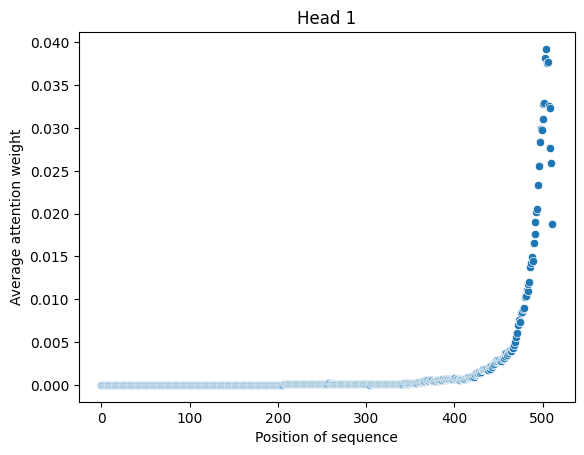

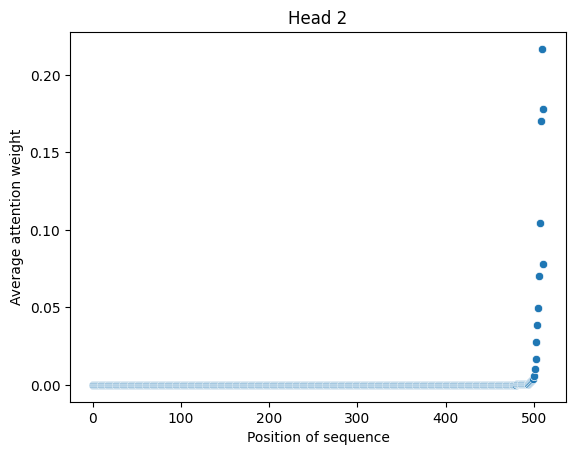

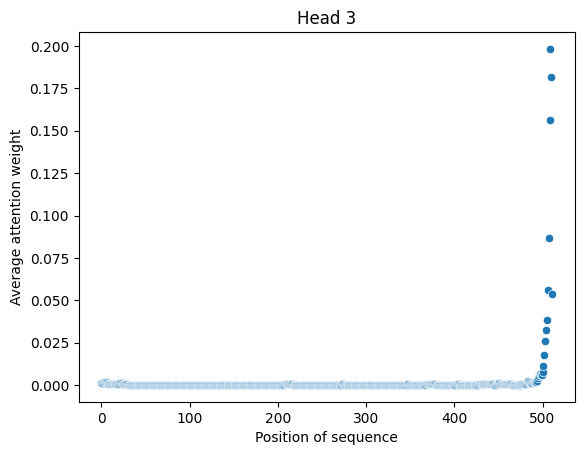

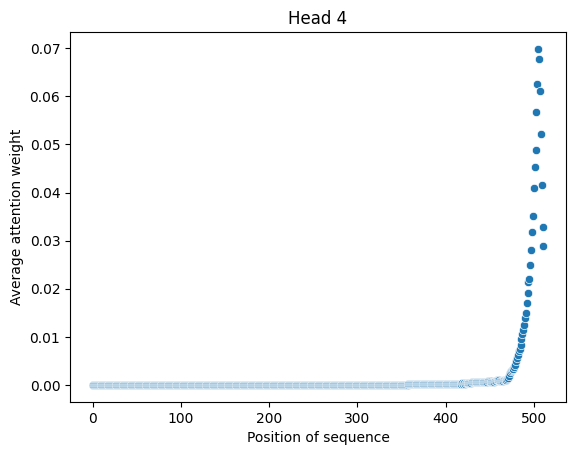

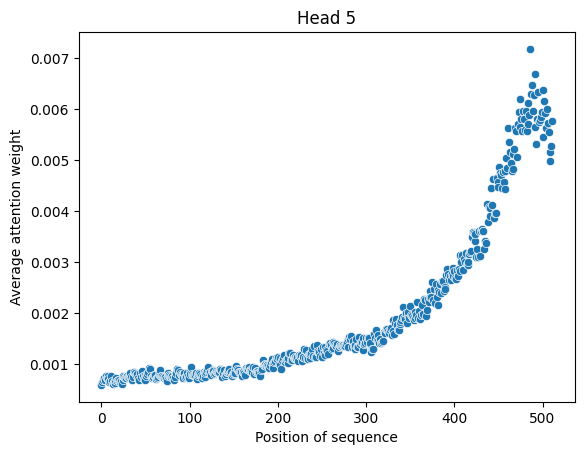

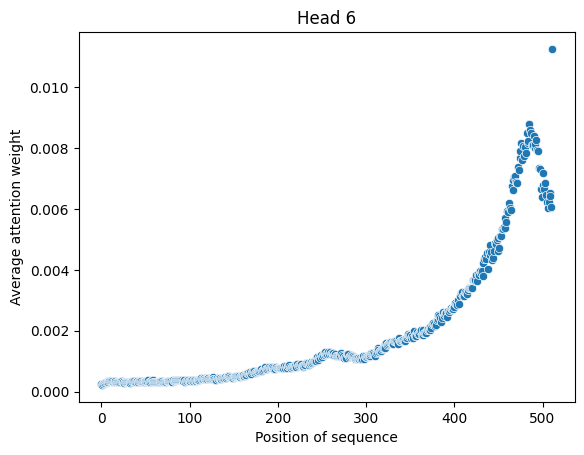

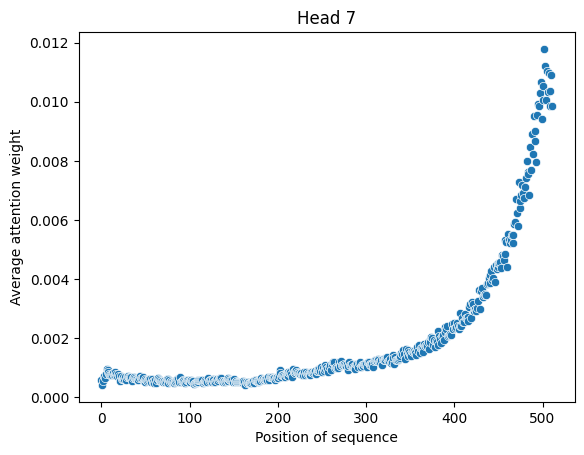

In [5]:
'''
Plot average attention weight vs. position of the sequence for all heads
'''
for i in range(8):
    df = pd.read_csv(EXPERIMENT_DIR / f'attn-stats-wdw={WINDOW_LENGTH}-stride={STRIDE}-head={i}.csv')
    weight_cols = [col for col in df if col.startswith('weight')]
    weight_df = df[weight_cols]
    avgs = weight_df.mean()
    sns.scatterplot(x=np.arange(WINDOW_LENGTH), y=avgs)
    plt.title(f'Head {i}')
    plt.xlabel('Position of sequence')
    plt.ylabel('Average attention weight')
    plt.show()

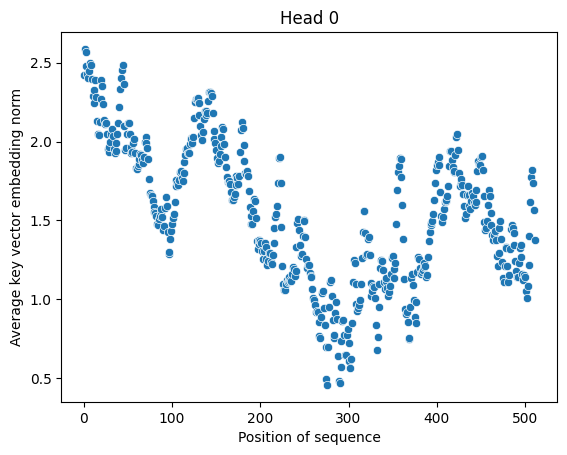

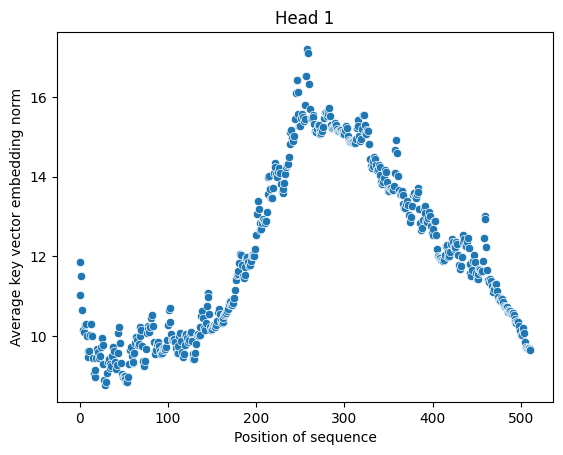

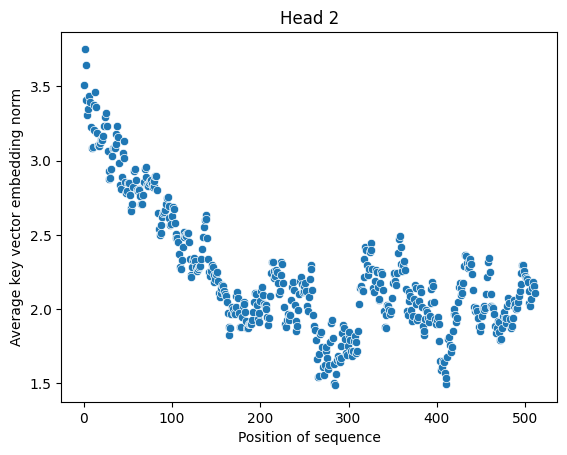

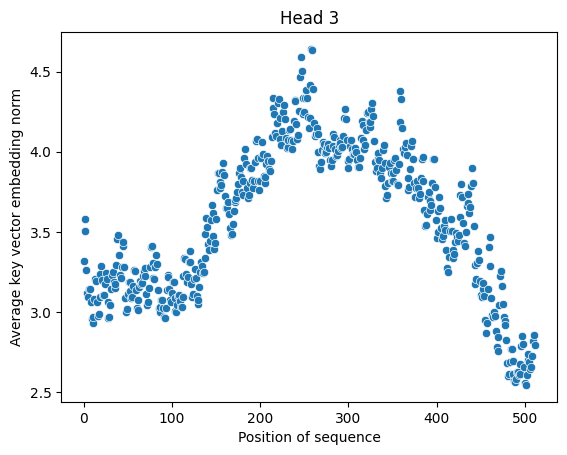

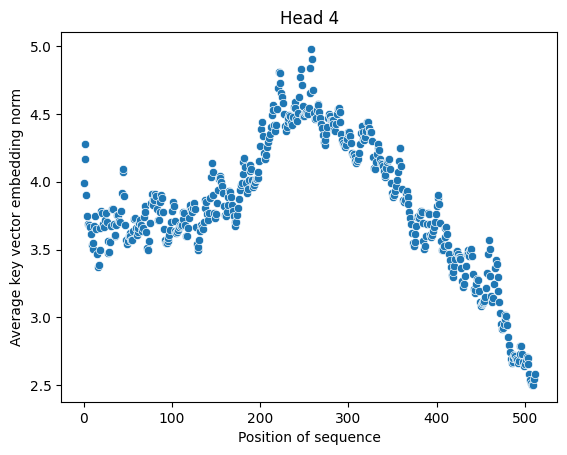

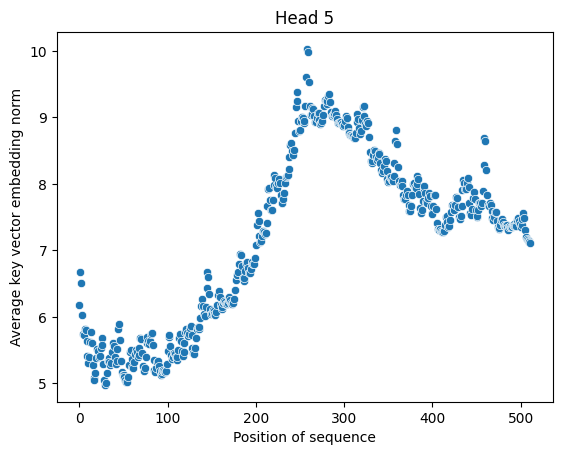

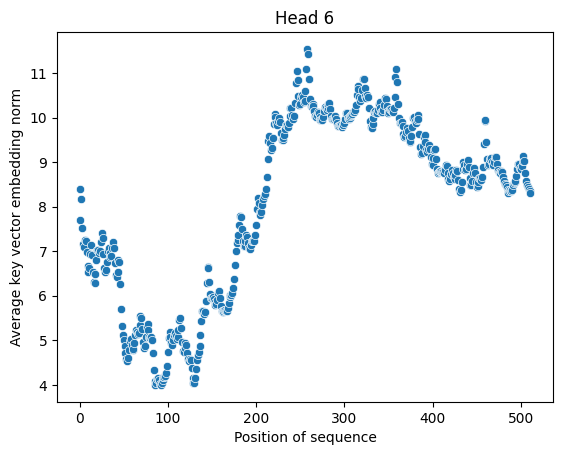

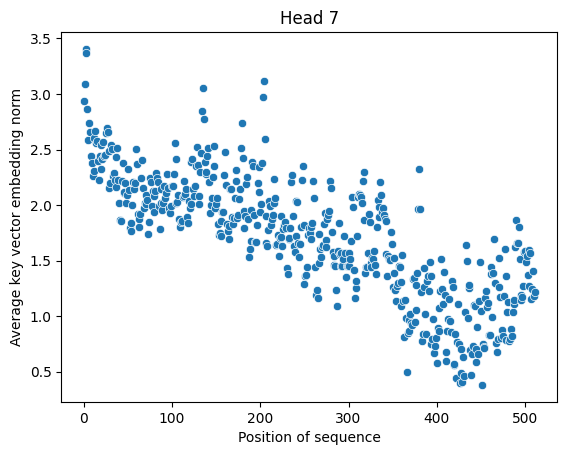

In [5]:
'''
Plot average key norm vs. position of the sequence for all heads
'''
for i in range(8):
    df = pd.read_csv(EXPERIMENT_DIR / f'attn-stats-wdw={WINDOW_LENGTH}-stride={STRIDE}-head={i}.csv')
    norm_cols = [col for col in df if col.startswith('norm')]
    norm_df = df[norm_cols]
    avg_norms = norm_df.mean()
    
    sns.scatterplot(x=np.arange(WINDOW_LENGTH), y=avg_norms)
    plt.title(f'Head {i}')
    plt.xlabel('Position of sequence')
    plt.ylabel('Average key vector embedding norm')
    plt.show()

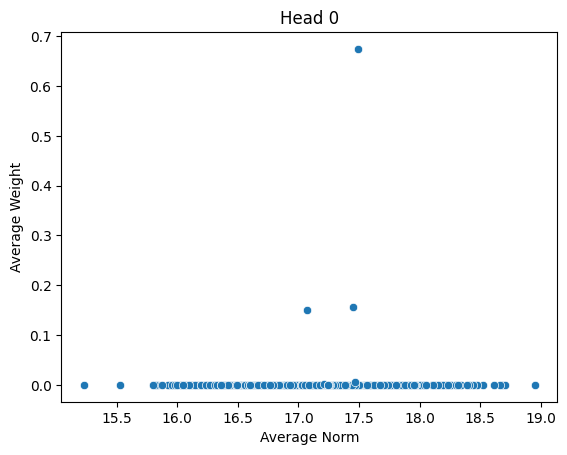

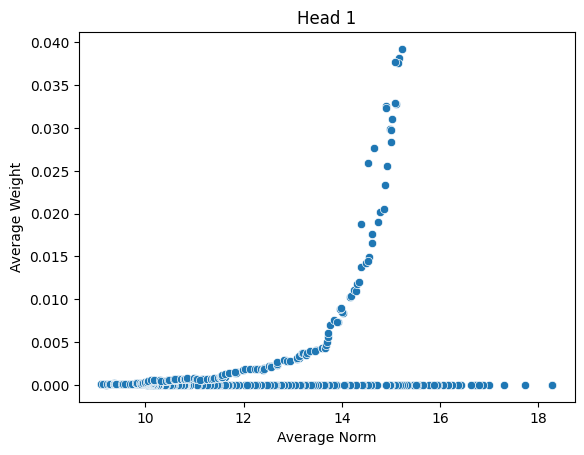

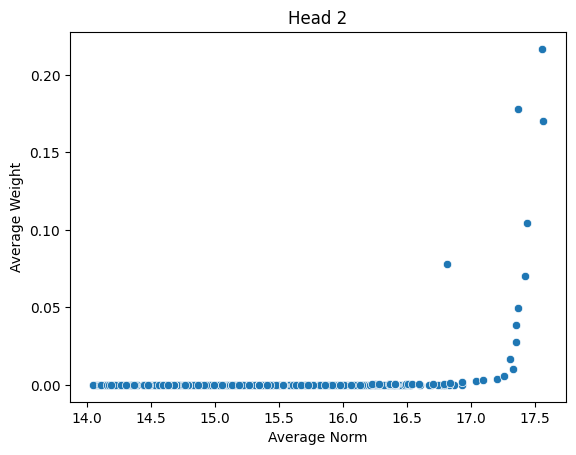

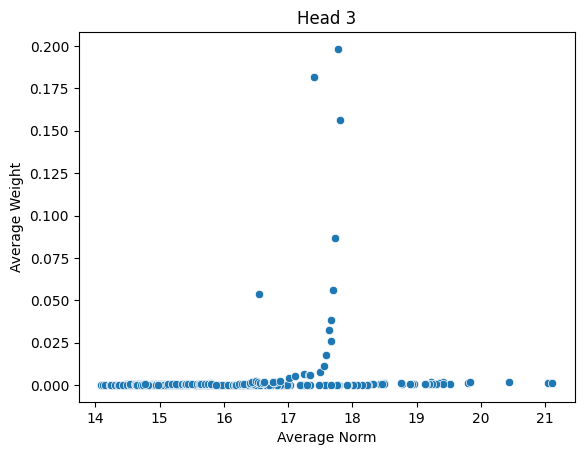

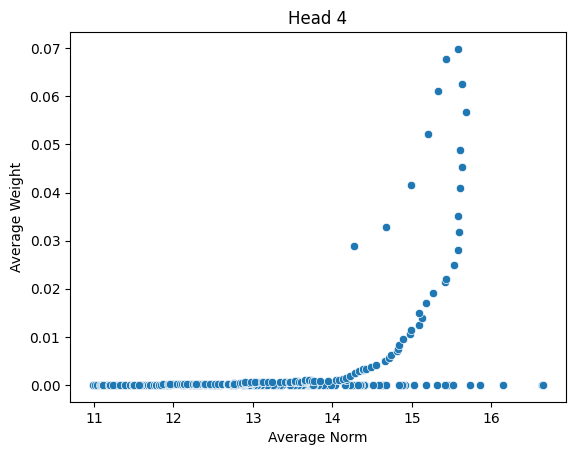

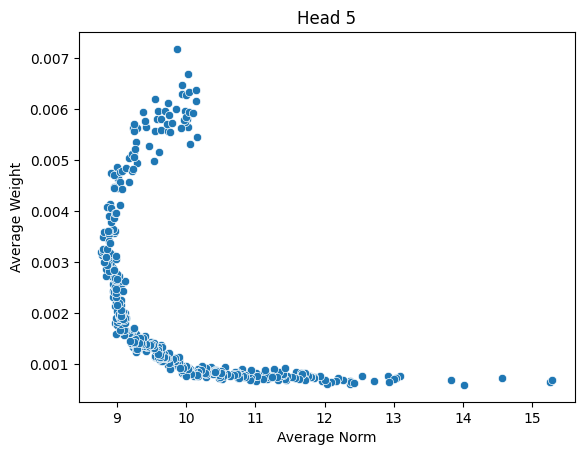

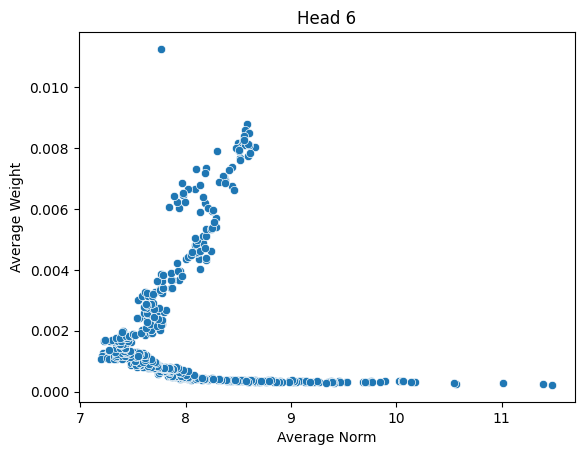

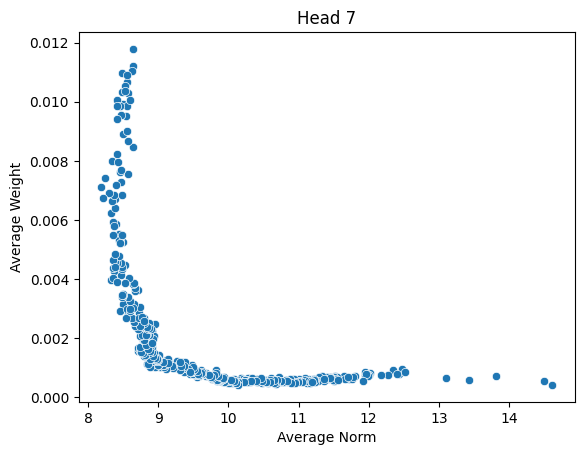

In [6]:
'''
Plot average key norm vs. average attention weight for each position of the sequence for all heads
'''
for i in range(8):
    df = pd.read_csv(EXPERIMENT_DIR / f'attn-stats-wdw={WINDOW_LENGTH}-stride={STRIDE}-head={i}.csv')
    norm_cols = [col for col in df if col.startswith('norm')]
    norm_df = df[norm_cols]
    avg_norms = norm_df.mean()

    weight_cols = [col for col in df if col.startswith('weight')]
    weight_df = df[weight_cols]
    avg_weights = weight_df.mean()
    
    sns.scatterplot(x=avg_norms.values, y=avg_weights.values) # indexes don't line up, use .values to plot numpy arrays
    plt.title(f'Head {i}')
    plt.xlabel('Average Norm')
    plt.ylabel('Average Weight')
    plt.show()